---
$\texttt{Computer Imaging Project}$

$$
\texttt{ }
$$

$$
\texttt{SPARCITY AND PATCH FOR IMAGE RESTORATION}
$$

$$
\texttt{22 March 2022}
$$

$$
\texttt{-}
$$


$\Tiny{\texttt{By : Mohamed El Baha, Herve$'$ Silue$'$, Emmanuelle Bodji}}$
---





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Hervé path
%cd drive/MyDrive/IMT/labs\ computational\ imaging/ProjetCOMPIMG


[Errno 2] No such file or directory: 'drive/MyDrive/IMT/labs computational imaging/ProjetCOMPIMG'
/content/drive/MyDrive/IMT/labs computational imaging/ProjetCOMPIMG


$\texttt{CONTENT}$


1.   $\texttt{Introduction}$
2.   $\texttt{Selected approach}$
3.   $\texttt{Results}$
4.   $\texttt{Conclusion}$

---

### Introduction

In [ ]:
%matplotlib inline
# import imageio
import numpy as np
import matplotlib.pyplot as plt
import torch
from imageio import imread
from sklearn.feature_extraction import image
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
import pandas as pd
from numpy import linalg as LA
from src.normalizers import BandMinMaxQuantileStateful
from src.noise_models import BaseNoise, ConstantNoise, UniformNoise, CorrelatedNoise, StripesNoise
from sklearn.decomposition import PCA
import torch.nn as nn
import sklearn.decomposition
from torch.autograd import Variable
from IPython.core.pylabtools import figsize
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse

### Get data

In [ ]:
path_tif = 'Hyperspectral/Hyperspectral_Project/dc.tif'
full_img = torch.tensor(imread(path_tif), dtype=torch.float)

### Normalize data

In [ ]:
normalizer = BandMinMaxQuantileStateful()

#Normalize full image
normalizer.fit([full_img])
full_img = normalizer.transform(full_img)

### Split data

Text(0.5, 1.0, 'Test Image shape = torch.Size([191, 200, 200])')

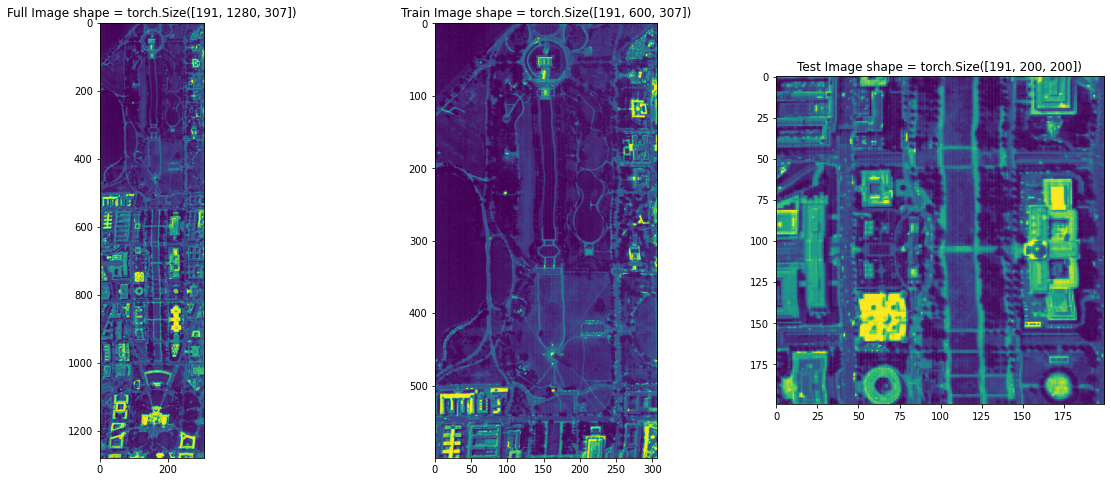

In [ ]:
test = full_img[:, 600:800, 50:250]
train_0 = full_img[:, :600, :]
train_1 = full_img[:, 800:, :]
val = full_img[:, 600:656, 251:]

fig, axes = plt.subplots(1,3, figsize = (20, 8))
ax = axes.ravel()

ax[0].imshow(full_img[1,:,:])
ax[0].set_title('Full Image shape = {0}'.format(full_img.shape))

ax[1].imshow(train_0[1,:,:])
ax[1].set_title('Train Image shape = {0}'.format(train_0.shape))

ax[2].imshow(test[1,:,:])
ax[2].set_title('Test Image shape = {0}'.format(test.shape))

In [ ]:
### Band = 20 to reduce RAM consuming
bands = 20
test = test[:bands,:,:]
train_0 = train_0[:bands,:,:]
train_1 = train_1[:bands,:,:]

In [ ]:
def resize_(img, bands_pos = 1):
  #bands_pos = 1, if band is at 1st position in img
  if bands_pos == 1:
    cp_img = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
    for ind in range(img.shape[0]):
      cp_img[:,:,ind] = img[ind,:,:]
  else:
    cp_img = np.zeros((img.shape[2], img.shape[0], img.shape[1]))
    for ind in range(img.shape[2]):
      cp_img[ind,:,:] = img[:,:,ind]
  return cp_img

In [ ]:
train_0 = resize_(train_0)
train_1 = resize_(train_1)

### Get patches

In [ ]:
p_x, p_y = 8, 8
patches_train_O = image.extract_patches_2d(train_0, (p_x, p_y))

### ACP for dictionnary construction

In [ ]:
dic = patches_train_O.reshape((patches_train_O.shape[0],-1))
print(dic.shape)

(177900, 1280)


In [ ]:
dim = 50
pca = PCA(dim)
pca.fit(dic)
pcs_ = pca.components_

In [ ]:
pcs_.shape

(50, 1280)

### After PCA

In [ ]:
class Encoder(torch.nn.Module):
  def __init__(self):
      super(Encoder, self).__init__()
      self.fc1 = torch.nn.Linear(p_x*p_y,pcs_.shape[0],bias=False)
      self.fc1.weight = torch.nn.Parameter(torch.Tensor(pcs_))
      self.mean_ = torch.nn.Parameter(torch.Tensor(pca.mean_))                  
  def forward(self, x):
      x = self.fc1(x.view(-1,p_x*p_y*bands) - self.mean_)
      return x

class Decoder(torch.nn.Module):
  def __init__(self):
      super(Decoder, self).__init__()
      self.fc1 = torch.nn.Linear(dim,p_x*p_y*bands,bias=False)
      self.fc1.weight = torch.nn.Parameter(torch.Tensor(pcs_.transpose()))
      self.mean_ = torch.nn.Parameter(torch.Tensor(pca.mean_))
  def forward(self, x):
      x = self.fc1(x) + self.mean_
      x = x.view(-1,p_x,p_y,bands)
      return x

In [ ]:
patches = patches_train_O
code = Encoder()
dec = Decoder()
patch_ = np.zeros((patches.shape))
i=0
for patch in patches:
  patch_enc=code.forward(torch.tensor(patch, dtype=torch.float))
  patch_dec=dec.forward(patch_enc)
  patch_dec = torch.squeeze(patch_dec)
  patch_np = patch_dec.cpu().detach().numpy()
  patch_[i,:,:,:]=patch_np
  i=i+1

Text(0.5, 1.0, 'Reconstruct image')

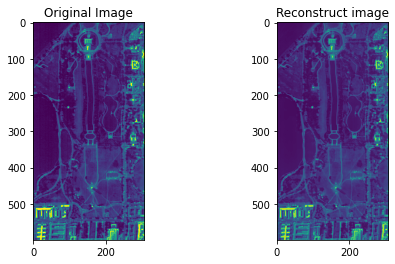

In [ ]:
reconstruct_img = reconstruct_from_patches_2d(patch_, train_0.shape)

fig, axes = plt.subplots(1,2, figsize = (8, 4))
ax = axes.ravel()

ax[0].imshow(train_0[:,:,1])
ax[0].set_title("Original Image")

ax[1].imshow(reconstruct_img[:,:,1])
ax[1].set_title("Reconstruct image")

### Metrics

In [ ]:
def mpsnr(original, denoised_img):
  mpsnr_=[]
  for ind in range(original.shape[0]):
    mpsnr_.append(psnr(original[ind,:,:], denoised_img[ind,:,:], data_range=1))
    return np.mean(mpsnr_)


def mssim(original, denoised_img):
  mssim_=[]
  for ind in range(original.shape[0]):
    mssim_.append(ssim(original[ind,:,:], denoised_img[ind,:,:], multichannel="False"))
    return np.mean(mssim_)

### Denoising algorithm

In [ ]:
def denoising(noise_img, Alpha_0, lambda_=0.1, Nb_iter=50, step_size=0.01):
  Alpha_i = Alpha_0
  r = torch.nn.ReLU()
  for i in range(Nb_iter):
    Alpha_i = Alpha_i + step_size * code.forward(noise_img - dec.forward(Alpha_i))
    Alpha_i = torch.sign(Alpha_i) * r(torch.abs(Alpha_i) - lambda_)
  return (Alpha_i)
  ### 
  # r = torch.nn.ReLU()
  # max (|u| - lambda, 0) <=> r(torch.abs(u) - lambda)
  #signe = torch.sign

In [ ]:
def get_clean_image(noised_image, initialization = 'random', p_x=8, p_y=8):

  noised_image = resize_(noised_image)

  noised_patches = image.extract_patches_2d(noised_image, (p_x, p_y))
  patches = noised_patches
  denoised_patch = np.zeros((patches.shape))
  num_patch = 0
  for patch in patches:
    patch_enc = code.forward(torch.tensor(patch, dtype=torch.float))
    #patch_enc = torch.rand(patch_enc.shape)
    denoise_p = dec.forward(denoising(torch.tensor(patch, dtype=torch.float), patch_enc))
    denoise_p = torch.squeeze(denoise_p)
    denoise_p = denoise_p.cpu().detach().numpy()
    denoised_patch[num_patch,:,:,:] = denoise_p
    num_patch = num_patch + 1
  return reconstruct_from_patches_2d(denoised_patch, noised_image.shape)

Noising & denoising images

In [ ]:
#Adding i.i.d. Gaussian noise with fixed σ per band
constant_noise_5 = ConstantNoise(5, bands)
original_image , constant_noise_5_test = constant_noise_5.apply(torch.tensor(test[None,:]), 1)
constant_noise_5_test = torch.squeeze(constant_noise_5_test)
constant_noise_5_test = constant_noise_5_test.cpu().detach().numpy()


constant_noise_25 = ConstantNoise(25, bands)
original_image , constant_noise_25_test = constant_noise_25.apply(torch.tensor(test[None,:]), 1)
constant_noise_25_test = torch.squeeze(constant_noise_25_test)
constant_noise_25_test = constant_noise_25_test.cpu().detach().numpy()


constant_noise_50 = ConstantNoise(50, bands)
original_image , constant_noise_50_test = constant_noise_50.apply(torch.tensor(test[None,:]), 1)
constant_noise_50_test = torch.squeeze(constant_noise_50_test)
constant_noise_50_test = constant_noise_50_test.cpu().detach().numpy()


constant_noise_100 = ConstantNoise(100, bands)
original_image , constant_noise_100_test = constant_noise_100.apply(torch.tensor(test[None,:]), 1)
constant_noise_100_test = torch.squeeze(constant_noise_100_test)
constant_noise_100_test = constant_noise_100_test.cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: Us

Text(0.5, 1.0, 'noise with fixed σ = 100 per band')

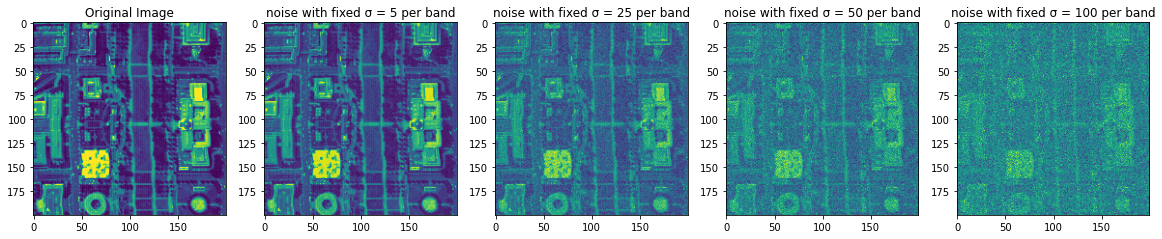

In [ ]:
#plot
original_image = torch.squeeze(original_image)
original_image = original_image.cpu().detach().numpy()

fig, axes = plt.subplots(1,5, figsize = (20, 8))
ax = axes.ravel()

ax[0].imshow(original_image[1,:,:])
ax[0].set_title("Original Image")

ax[1].imshow(constant_noise_5_test[1,:,:])
ax[1].set_title("noise with fixed σ = 5 per band")

ax[2].imshow(constant_noise_25_test[1,:,:])
ax[2].set_title("noise with fixed σ = 25 per band")

ax[3].imshow(constant_noise_50_test[1,:,:])
ax[3].set_title("noise with fixed σ = 50 per band")

ax[4].imshow(constant_noise_100_test[1,:,:])
ax[4].set_title("noise with fixed σ = 100 per band")


/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


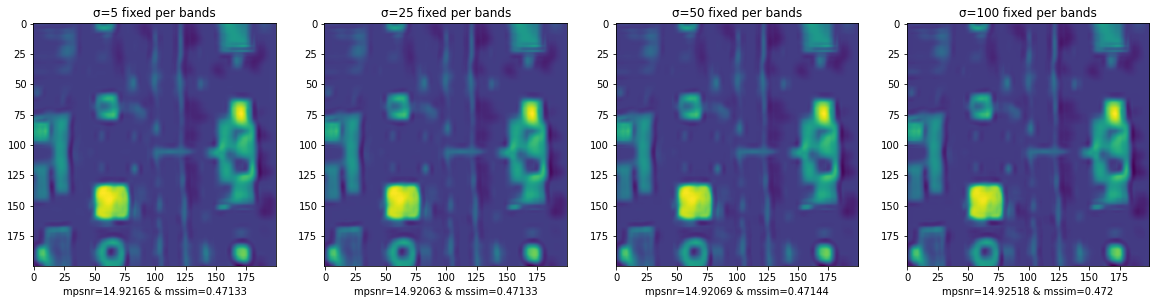

In [ ]:
fig, axes = plt.subplots(1,4, figsize = (20, 15))
ax = axes.ravel()
i=0
sigma = [5, 25, 50, 100]
for noised_img in [constant_noise_5_test, constant_noise_25_test, constant_noise_50_test, constant_noise_100_test]:
  #print(noised_img)
  clean_img = get_clean_image(noised_img)

  mpsnr1 = mpsnr(test.cpu().detach().numpy(), resize_(clean_img, 2))
  mssim1 = mssim(test.cpu().detach().numpy(), resize_(clean_img, 2))
  
  ax[i].imshow(clean_img[:,:,1])
  ax[i].set_title('σ={0} fixed per bands'.format(sigma[i]))
  ax[i].set_xlabel('mpsnr={0} & mssim={1}'.format(round(mpsnr1,5), round(mssim1,5)))
  i=i+1

In [ ]:
#Adding noise level that depends on the band, taken uniformly on small interval
uniform_noise_0_15 = UniformNoise(0, 15)
original_image , uniform_noise_0_15_test = uniform_noise_0_15.apply(torch.tensor(test[None,:]), 1)
uniform_noise_0_15_test = torch.squeeze(uniform_noise_0_15_test)
uniform_noise_0_15_test = uniform_noise_0_15_test.cpu().detach().numpy()


uniform_noise_0_55 = UniformNoise(0, 55)
original_image , uniform_noise_0_55_test = uniform_noise_0_55.apply(torch.tensor(test[None,:]), 1)
uniform_noise_0_55_test = torch.squeeze(uniform_noise_0_55_test)
uniform_noise_0_55_test = uniform_noise_0_55_test.cpu().detach().numpy()


uniform_noise_0_95 = UniformNoise(0, 95)
original_image , uniform_noise_0_95_test = uniform_noise_0_95.apply(torch.tensor(test[None,:]), 1)
uniform_noise_0_95_test = torch.squeeze(uniform_noise_0_95_test)
uniform_noise_0_95_test = uniform_noise_0_95_test.cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'noise depends on the band, σ in [0,95]')

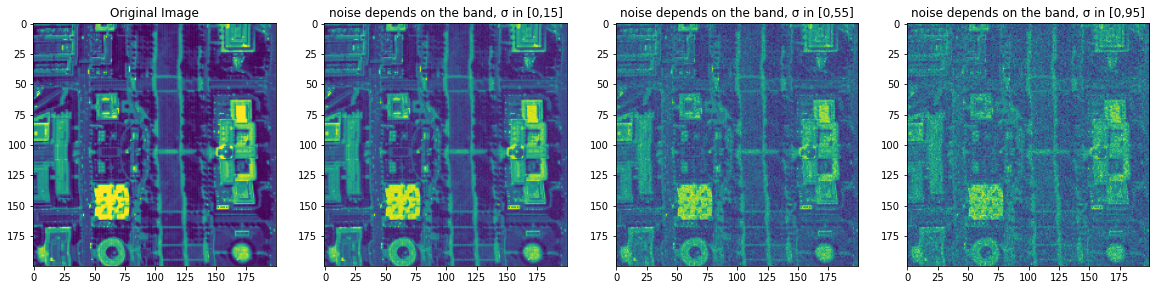

In [ ]:
#plot
original_image = torch.squeeze(original_image)
original_image = original_image.cpu().detach().numpy()

fig, axes = plt.subplots(1,4, figsize = (20, 8))
ax = axes.ravel()

ax[0].imshow(original_image[1,:,:])
ax[0].set_title("Original Image")

ax[1].imshow(uniform_noise_0_15_test[1,:,:])
ax[1].set_title("noise depends on the band, σ in [0,15]")

ax[2].imshow(uniform_noise_0_55_test[1,:,:])
ax[2].set_title("noise depends on the band, σ in [0,55]")

ax[3].imshow(uniform_noise_0_95_test[1,:,:])
ax[3].set_title("noise depends on the band, σ in [0,95]")


/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


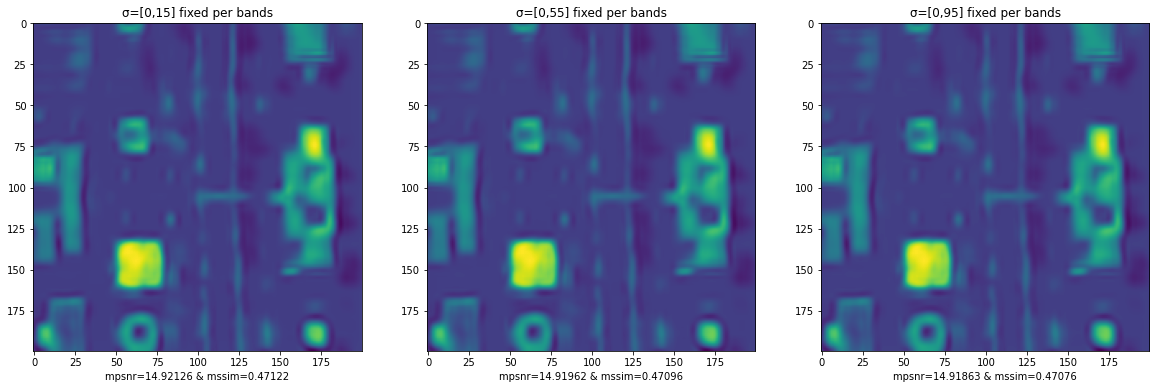

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (20, 8))
ax = axes.ravel()
i=0
sigma = ['[0,15]', '[0,55]', '[0,95]']
num_iter = 10
for noised_img in [uniform_noise_0_15_test, uniform_noise_0_55_test, uniform_noise_0_95_test]:
  clean_img = get_clean_image(noised_img)

  mpsnr1 = mpsnr(test.cpu().detach().numpy(), resize_(clean_img, 2))
  mssim1 = mssim(test.cpu().detach().numpy(), resize_(clean_img, 2))

  ax[i].imshow(clean_img[:,:,1])
  ax[i].set_title('σ={0} fixed per bands'.format(sigma[i]))
  ax[i].set_xlabel('mpsnr={0} & mssim={1}'.format(round(mpsnr1,5), round(mssim1,5)))
  i=i+1
  

In [ ]:
#Adding correlated noise with σ across band
#base_noise = BaseNoise()
#correlated_noise = CorrelatedNoise(base_noise)

In [ ]:
#Adding stripe noise
stripes_noise = StripesNoise(bands)
original_image , stripes_noise_test = stripes_noise.apply(torch.tensor(test), 1)
stripes_noise_test = torch.squeeze(stripes_noise_test)
stripes_noise_test = stripes_noise_test.cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'stripe noised image')

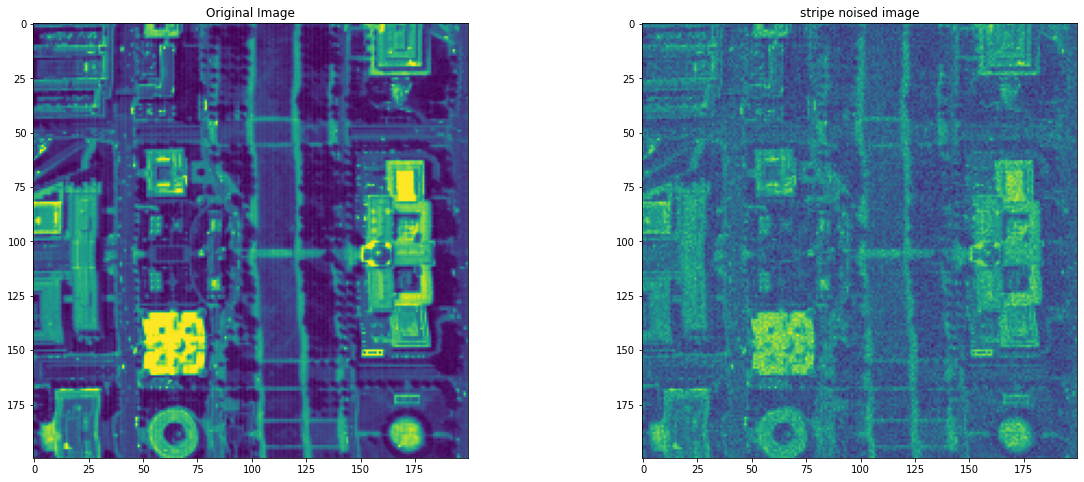

In [ ]:
#plot
original_image = torch.squeeze(original_image)
original_image = original_image.cpu().detach().numpy()

fig, axes = plt.subplots(1,2, figsize = (20, 8))
ax = axes.ravel()

ax[0].imshow(original_image[1,:,:])
ax[0].set_title("Original Image")

ax[1].imshow(stripes_noise_test[1,:,:])
ax[1].set_title("stripe noised image")

In [ ]:
clean_img = get_clean_image(stripes_noise_test)

mpsnr1 = mpsnr(test.cpu().detach().numpy(), resize_(clean_img, 2))
mssim1 = mssim(test.cpu().detach().numpy(), resize_(clean_img, 2))



/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


Text(0.5, 0, 'mpsnr=14.92927 & mssim=0.47131')

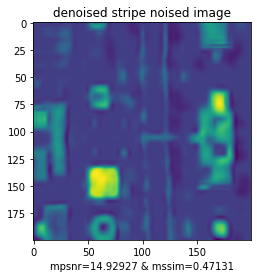

In [ ]:
plt.imshow(clean_img[:,:,1])

plt.title('denoised stripe noised image')
plt.xlabel('mpsnr={0} & mssim={1}'.format(round(mpsnr1,5), round(mssim1,5)))

Text(0.5, 0, 'mpsnr=14.92927 & mssim=0.47131')

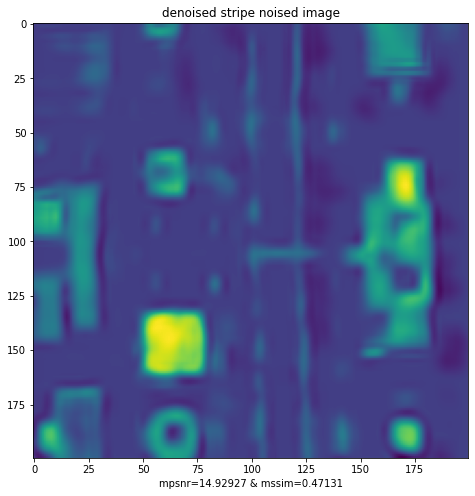

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(clean_img[:,:,1])

plt.title('denoised stripe noised image')
plt.xlabel('mpsnr={0} & mssim={1}'.format(round(mpsnr1,5), round(mssim1,5)))